# Poisson Equation
We consider the two dimensional Poisson equation for two PINNs as in https://arxiv.org/pdf/2109.09444.pdf.
$$
\begin{cases}
    u_{xx} + u_{yy} = f \text{ for } (x,y)\in [0,1]\times [0,1] \\
    u(0, y) = u(1, y) = u(x, 0) = u(x, 1)= 0 \\
\end{cases}
$$

In this case, we consider:
$$
\begin{cases}
    f = 1 \text{ for }(x,y)\in [0.25,0.75] \times [0.25,0.75]\\
    f = 0 \text{    else}
\end{cases}
$$

In [1]:
from xpinn import XPINN
import optax
from type_util import Array
from jax import hessian, jacobian, jit, vmap
import jax.numpy as np
import numpy as onp
import sys
from tqdm import tqdm
from utils import data_path
from base_network import neural_network
from poisson.poisson_utils import boundary_loss_factory, interior_loss_factory, crude_rel_L2, interface_loss_factory
import plotutils

In [2]:
### Run point generation
%run XPINN_test_points.py
%run XPINN_points.py

(651, 2)
(249, 2)


## Initializing the PINN

In [3]:
### Set files
name = str(sys.argv[1])
file = data_path / "poisson_train.json"
file_test = data_path / "poisson_test.json"
activation = np.tanh

In [4]:
### Set model (FFNN)
xpinn = XPINN(file, activation)
model = neural_network(activation)
v_model = vmap(model, (None, 0))

We visualize the points of the domain decomposition.

(651, 2)
(120, 2)
(249, 2)
(80, 2)


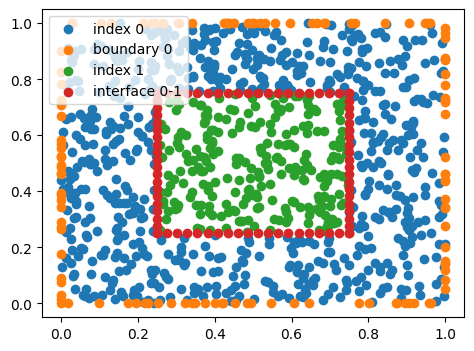

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)

for i, pinn in enumerate(xpinn.PINNs):
    checkout = pinn.interior
    print(pinn.interior.shape)
    plt.scatter(checkout[:, 0], checkout[:, 1], label=f"index {i}")
    if pinn.boundary.size != 0:
        print(pinn.boundary.shape)
        plt.scatter(pinn.boundary[:, 0], pinn.boundary[:, 1], label=f"boundary {i}")

for interface in xpinn.Interfaces:
    a, b = interface.indices
    p = interface.points
    print(p.shape)
    plt.scatter(p[:, 0], p[:, 1], label=f"interface {a}-{b}")

plt.legend()
#plt.savefig(fig_path / f"Poisson/xpinn_decomp.pdf")

### PINN Formalization
We only consider boundary loss for the outer PINN.

### Setting the true solution

In [6]:
### Set true solution and RHS
@jit
def u_star(x):
    return np.prod(np.sin(np.pi * x))

# rhs
@jit
def f(x):
    return 2. * np.pi**2 * u_star(x)

f_v = f
f_final = jit(f_v)

### Setting the loss function

In [7]:
# Set losses
p0, p1 = xpinn.PINNs
p0.boundary_loss = boundary_loss_factory(p0,0.0)
p0.interior_loss = interior_loss_factory(p0, f)  # implementing rhs
p1.interior_loss = interior_loss_factory(p1, f)
p0.interface_loss = interface_loss_factory(xpinn,0, 1)
p1.interface_loss = interface_loss_factory(xpinn,1, 0)

In [8]:
@jit
def u_star(x):
    return np.prod(np.sin(np.pi * x))

# rhs
@jit
def f(x):
    return 2. * np.pi**2 * u_star(x)

f_v = f
f_final = jit(f_v)

Setting the boundary and interior loss

In [9]:
# Set losses
p0, p1 = xpinn.PINNs
p0.boundary_loss = boundary_loss_factory(p0,0.0)
p0.interior_loss = interior_loss_factory(p0, f)  # implementing rhs
p1.interior_loss = interior_loss_factory(p1, f)
p0.interface_loss = interface_loss_factory(xpinn,0, 1)
p1.interface_loss = interface_loss_factory(xpinn,1, 0)

Initializing the optimizer

In [10]:
### Initializing optimizer
shapes = [[2] + [64] + [1],[2] + [64] + [1]]
exponential_decay = optax.exponential_decay(
        init_value=0.001,
        transition_steps=10000,
        transition_begin=15000,
        decay_rate=0.1,
        end_value=0.0000001,
    )
optimizer = optax.adam(learning_rate=exponential_decay)
xpinn.initialize_params(shapes, optimizer)

In [11]:
### Setting iterations
n_iter = 200000
xpinn.set_loss()
losses = xpinn.run_iters(n_iter)

0.00% iter = 0 of 200000: Total loss = 306.1030921936035
10.00% iter = 20000 of 200000: Total loss = 0.002078744175378233
20.00% iter = 40000 of 200000: Total loss = 0.0008289213292300701
30.00% iter = 60000 of 200000: Total loss = 0.0007313410751521587
40.00% iter = 80000 of 200000: Total loss = 0.0007157903164625168
50.00% iter = 100000 of 200000: Total loss = 0.0007008104294072837
60.00% iter = 120000 of 200000: Total loss = 0.0006860306020826101
70.00% iter = 140000 of 200000: Total loss = 0.0006715171039104462
80.00% iter = 160000 of 200000: Total loss = 0.0006572952843271196
90.00% iter = 180000 of 200000: Total loss = 0.0006432723021134734
100.00% iter = 200000 of 200000: Total loss = 0.0006295742350630462


In [12]:
#a_losses = losses
#t_0 = 0
#t_end = min(200000, n_iter)
#t = np.arange(t_0, t_end)
#
#for i in range(2):
#    plt.plot(t, a_losses[i, t_0:t_end], label=f"PINN {i}")
#plt.plot(t, np.sum(a_losses, axis=0)[t_0:t_end], "--", label="Total loss")
#plt.xlabel("epoch")
#plt.ylabel("loss")
#plt.yscale("log")
#plt.legend()
#plt.title(f"Loss per Pinn over {n_iter} epochs")

In [13]:
points, predictions = xpinn.predict(file_test)
total_points = np.concatenate(points)
total_pred = np.concatenate(predictions)
sorted_indices = np.lexsort((total_points[:,1],total_points[:,0]))
sorted_pred = total_pred[sorted_indices]
sorted_points = total_points[sorted_indices]
true_value = np.sin(np.pi * sorted_points[:, 0])* np.sin(np.pi * sorted_points[:, 1])

In [14]:
print(true_value.shape, type(onp.array(true_value)))
sorted_pred2= sorted_pred.reshape(-1)
print(type(onp.array(sorted_pred2)))

(996004,) <class 'numpy.ndarray'>
<class 'numpy.ndarray'>


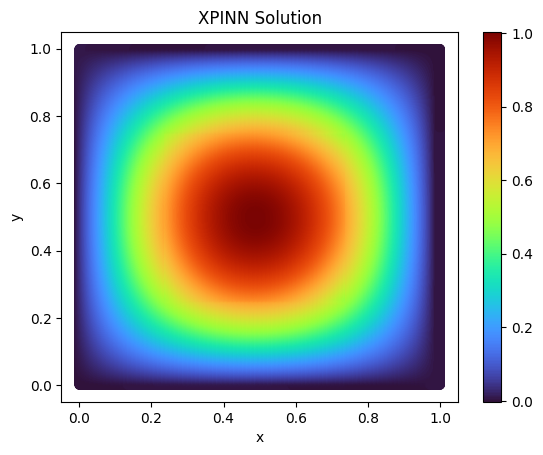

In [15]:
plt.scatter(sorted_points[:,0], sorted_points[:,1], c=sorted_pred, cmap="turbo")
plt.xlabel("x")
plt.ylabel("y")
plt.title("XPINN Solution")
plt.colorbar()

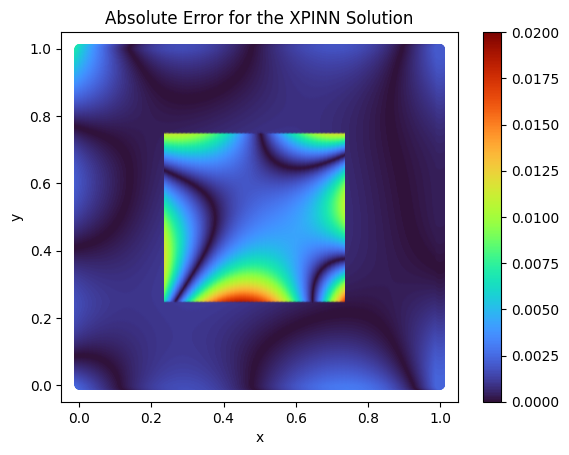

In [17]:
error = np.abs(sorted_pred2- true_value)
onp.savez("testing", error)
plt.scatter(sorted_points[:,0], sorted_points[:,1], c=error,  cmap="turbo")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Absolute Error for the XPINN Solution")
plt.clim(0, 0.02)
plt.colorbar()